# General Functions

In [1]:
def label_col(row):
  if row['labels'] == 'Non-anti-LGBT+ content':
    return 0
  elif row['labels'] == 'Homophobic':
    return 1
  elif row['labels'] == 'Transphobic':
    return 2

In [2]:
def label_col_Hope(row):
  if row['labels'] == 'Non_hope_speech;;':
    return 1
  elif row['labels'] == 'Hope_speech;;':
    return 0
  elif row['labels'] == 'Non_hope_speech;':
    return 1
  elif row['labels'] == 'Hope_speech;':
    return 0
  elif row['labels'] == 'Non_hope_speech':
    return 1
  elif row['labels'] == 'Hope_speech':
    return 0

In [3]:
# Returns the F1 score computed on the predictions
def f1_score_func(preds, labels):
    preds_flat=np.argmax(preds, axis=1).flatten()
    labels_flat=labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')
    
# Returns the precision, accuracy and recall score computed on the predictions
def prec_func(preds, labels):
    preds_flat=np.argmax(preds, axis=1).flatten()
    labels_flat=labels.flatten()
    return precision_score(labels_flat, preds_flat, average='weighted')

def recall_func(preds, labels):
    preds_flat=np.argmax(preds, axis=1).flatten()
    labels_flat=labels.flatten()
    return recall_score(labels_flat, preds_flat, average='weighted')

def acc_func(preds, labels):
    preds_flat=np.argmax(preds, axis=1).flatten()
    labels_flat=labels.flatten()
    return accuracy_score(labels_flat, preds_flat)

In [4]:
# Evaluates the model using the validation set
def evaluate(model, dataloader_val):
  model.eval()
  loss_val_total = 0
  predictions, true_vals = [], []

  for batch in dataloader_val:
      batch = tuple(b.to(device) for b in batch)
      inputs = {'input_ids': batch[0],
        'attention_mask': batch[1],
        'labels': batch[2],
        }

      with torch.no_grad():
          outputs = model(**inputs)

      loss = outputs[0]
      logits = outputs[1]
      loss_val_total += loss.item()

      logits = logits.detach().cpu().numpy()
      label_ids = inputs['labels'].cpu().numpy()
      predictions.append(logits)
      true_vals.append(label_ids)

  loss_val_avg = loss_val_total / len(dataloader_val)

  predictions = np.concatenate(predictions, axis=0)
  true_vals = np.concatenate(true_vals, axis=0)

  return loss_val_avg, predictions, true_vals

In [43]:
# Evaluates the model using the validation set
def predict(dataset_test):
    predictions = []
    probas = []
    for row in dataset_test:
      row = tuple(r.to(device) for r in row)
      inputs = {'input_ids': row[0],
        'attention_mask': row[1]
        }

      with torch.no_grad():
          outputs = model(**inputs)

      logits = outputs[0]
      probas.append(F.softmax(logits, dim=-1))
      logits = logits.detach().cpu().numpy()
      predictions.append(logits)

    return probas,predictions

In [44]:
def trainBERT(data):
  scores = []
  # Split dataset in traning and validation(test)
  X_train, X_val, Y_train, Y_val = train_test_split(
      data.index.values,
      data.labels.values,
      test_size=0.10,
      random_state=17,
      stratify=data.labels.values
  )
  # Check datasets composition
  data['data_type'] = ['not_set'] * data.shape[0]
  data.loc[X_train, 'data_type'] = 'train'
  data.loc[X_val, 'data_type'] = 'val'
  print("[print in trainBERT] -- Data Composition ")
  print(data.groupby(['labels', 'data_type']).count())
  print("[print in trainBERT] -- Len Train "+str(len(data)))
  data = data.dropna()
  print("[print in trainBERT] -- Len Train after dropping NaN "+str(len(data)))
  # Encode training dataset using the tokenizer
  encoded_data_train = tokenizer.batch_encode_plus(
      data[data.data_type == 'train'].text.values,
      add_special_tokens=True,
      return_attention_mask=True, 
      pad_to_max_length=True,
      max_length=256,
      return_tensors='pt'
  )
  # Encode validation dataset using the tokenizer
  encoded_data_val = tokenizer.batch_encode_plus(
      data[data.data_type == 'val'].text.values,
      add_special_tokens=True,
      return_attention_mask=True,  
      pad_to_max_length=True,
      max_length=256,
      return_tensors='pt'
  )
  # Extract IDs, attention masks and labels from training dataset
  input_ids_train = encoded_data_train['input_ids']
  attention_masks_train = encoded_data_train['attention_mask']
  labels_train = torch.tensor(data[data.data_type == 'train'].labels.values)
  # Extract IDs, attention masks and labels from validation dataset
  input_ids_val = encoded_data_val['input_ids']
  attention_masks_val = encoded_data_val['attention_mask']
  labels_val = torch.tensor(data[data.data_type == 'val'].labels.values)
  # Create train and validation dataset from extracted features
  dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
  dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

  # Define the size of each batch
  batch_size = 4

  # Load training dataset
  dataloader_train= DataLoader(
      dataset_train,
      sampler=RandomSampler(dataset_train),
      batch_size=batch_size)

  # Load valuation dataset
  dataloader_val= DataLoader(
      dataset_val,
      sampler=RandomSampler(dataset_val),
      batch_size=batch_size)

  # Load pre-trained BERT model
  model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                        num_labels = 3,
                                                        output_attentions = False,
                                                        output_hidden_states = False)

  model.to(device)  

  # Define model optimizer -> Adam
  optimizer = AdamW(
      model.parameters(),
      lr = 1e-5, 
      eps=1e-8
  )

  # Define model scheduler
  epochs = 4
  scheduler = get_linear_schedule_with_warmup(optimizer,
                                              num_warmup_steps=0,
                                              num_training_steps=len(dataloader_train)*epochs)
  # Define random seeds
  seed_val = 17
  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)
  
  for epoch in tqdm(range(1, epochs + 1)):

      model.train()  # model is training

      loss_train_total = 0

      progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
      for batch in progress_bar:
          model.zero_grad()
          batch = tuple(b.to(device) for b in batch)
          inputs = {'input_ids': batch[0],
                    'attention_mask': batch[1],
                    'labels': batch[2]}
          
          outputs = model(**inputs)

          loss = outputs[0]
          loss_train_total += loss.item()
          loss.backward()  # to backpropagate

          torch.nn.utils.clip_grad_norm_(model.parameters(),
                                        1.0)  # prevents the gradient from being too small or too big

          optimizer.step()
          scheduler.step()
          progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})

      
      torch.save(model, path)
      tqdm.write(f'\nEpoch {epoch}/{epochs}')

      loss_train_avg = loss_train_total / len(dataloader_train)
      tqdm.write(f'Training loss: {loss_train_avg}')  # make sure that model is still training

      val_loss, predictions, true_vals = evaluate(model,dataloader_val)  # to check overtraining (or overfitting)
      val_f1 = f1_score_func(predictions, true_vals)
      val_prec = prec_func(predictions, true_vals)
      val_recall = recall_func(predictions, true_vals)
      val_acc = acc_func(predictions, true_vals)

      scores.append(val_f1)

      tqdm.write(f'Validation loss: {val_loss}')
      tqdm.write(f'F1 Score(weighted) : {val_f1}')
      tqdm.write(f'Prec Score(weighted) : {val_prec}')
      tqdm.write(f'Recall Score(weighted) : {val_recall}')
      tqdm.write(f'Acc Score : {val_acc}')
  score = max(scores)
  return model,score 

Arianna's code: only addition, here we save in addition to the prediction, the probabilities returned for the class 1, i.e., hope_speech

In [45]:
def predOnTestData(data_test):
  # Encode validation dataset using the tokenizer
  encoded_data_test = tokenizer.batch_encode_plus(
      data_test.text.values,
      add_special_tokens=True,
      return_attention_mask=True,  
      pad_to_max_length=True,
      max_length=256,
      return_tensors='pt'
  )

  # Extract IDs, attention masks and labels from validation dataset
  input_ids_test = encoded_data_test['input_ids']
  attention_masks_test = encoded_data_test['attention_mask']
  dataset_test = TensorDataset(input_ids_test, attention_masks_test)
  dataloader_test = DataLoader(dataset_test)
  
  # Predict values for test dataset
  probas,predictions = predict(dataloader_test)
  results = []
  for i, prediction in enumerate(predictions):
    predicted = np.argmax(prediction, axis=1)[0]
    results.append(predicted)
  pred = []
  for prediction in results:
    pred.append(prediction)
  data_test['pred'] = pred

  # We save the proba for each of the three labels 
  probs_0 = []
  probs_1 = []
  probs_2 = []
  for pro in probas:
    probs_0.append(pro[0].cpu().numpy()[0])  
    probs_1.append(pro[0].cpu().numpy()[1])  
    probs_2.append(pro[0].cpu().numpy()[2])  
  data_test['probs_0'] = probs_0
  data_test['probs_1'] = probs_1
  data_test['probs_2'] = probs_2
  return data_test 

In [46]:
def findTopK(data_test, k):
  while len(data_test) > k:
    sorted_data_test1 = pd.DataFrame()
    sorted_data_test2 = pd.DataFrame()
    if len(data_test[data_test["pred"] == 1]) > k:
      probs = 'probs_1'
      # Sort the poolData w.r.t. proba of label
      sorted_data_test1 = data_test.sort_values(by=probs, ascending=False)
      # Keep only the top-k
      sorted_data_test1 = sorted_data_test1[:k]
      sorted_data_test1 = sorted_data_test1[sorted_data_test1[probs] >= 0.7] 
      # Dropping from the poolData the top-k 
      data_test = data_test.drop(index=list(sorted_data_test1.index))
    if len(data_test[data_test["pred"] == 2]) > k:
      probs = 'probs_2'
      # Sort the poolData w.r.t. proba of label
      sorted_data_test2 = data_test.sort_values(by=probs, ascending=False)
      # Keep only the top-k
      sorted_data_test2 = sorted_data_test2[:k]
      sorted_data_test2 = sorted_data_test2[sorted_data_test2[probs] >= 0.7] 
      # Dropping from the poolData the top-k 
      data_test = data_test.drop(index=list(sorted_data_test2.index))
    
    sorted_data_test = pd.concat([sorted_data_test1,sorted_data_test2])
    
    print("[print in findTopK] -- Len poolData after removing topK for both classes"+str(len(data_test)))
    
    # Resetting the index of the two subsets 
    if not sorted_data_test.empty:
      sorted_data_test = sorted_data_test.reset_index()
      sorted_data_test=sorted_data_test.drop(['index'], 1)  
      sorted_data_test=sorted_data_test.drop(['pred'], 1) 
      sorted_data_test=sorted_data_test.drop(['probs_0'], 1) 
      sorted_data_test=sorted_data_test.drop(['probs_1'], 1) 
      sorted_data_test=sorted_data_test.drop(['probs_2'], 1) 
    data_test = data_test.reset_index()
    data_test=data_test.drop(['index'], 1) 
    data_test=data_test.drop(['pred'], 1) 
    data_test=data_test.drop(['probs_0'], 1) 
    data_test=data_test.drop(['probs_1'], 1) 
    data_test=data_test.drop(['probs_2'], 1) 
    print("[print in findTopK] -- Print topK")
    print(sorted_data_test)
    print("[print in findTopK] -- Print remaining poolData")
    print(data_test)
    # Returning the two subsets 
    return sorted_data_test,data_test 

# Requirements & Imports

In [5]:
!pip install transformers
!pip install bert-tensorflow

     |████████████████████████████████| 3.5 MB 5.4 MB/s 
     |████████████████████████████████| 67 kB 5.5 MB/s 
     |████████████████████████████████| 895 kB 48.8 MB/s 
     |████████████████████████████████| 6.8 MB 30.3 MB/s 
     |████████████████████████████████| 596 kB 46.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 64 kB 1.9 MB/s 


In [6]:
import tensorflow as tf
import torch
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
import random
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report

In [7]:
from google.colab import drive
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Model trained on train + dev of Homo

## Prep. Data from 'Homo/Trans'

Up to now, we have trained the model on the dataset 'HOPE SPEECH'. We will predict on HOMO/TRANS training set.

In [10]:
pip install openpyxl==3.0.9

In [11]:
import openpyxl
test = pd.read_excel("homo_train.xlsx")
test.columns = ['labels', 'text']
test = test.dropna()
test

,labels,text
0,Non-anti-LGBT+ content,"I support her, very smart ponnu"
1,Homophobic,priyadharshini kannan same gender attraction ...
2,Non-anti-LGBT+ content,Bro u name and phone number (or)mobile number ...
3,Non-anti-LGBT+ content,experience Thaks bro I love you so much bro ...
4,Non-anti-LGBT+ content,world is becoming bad day by day....
...,...,...
4084,Transphobic,"Alas, where did the transgender Aravanis Alis ..."
4085,Transphobic,You are a transgender. That's why we talk abou...
4086,Transphobic,Vijay Kumar You too 9 Thana
4087,Transphobic,chandra lekha 9 for one time 9 for another 9 i...


In [12]:
test.labels.value_counts()

Non-anti-LGBT+ content    3732
Homophobic                 215
Transphobic                141
Name: labels, dtype: int64

In [13]:
test['labels'] = test.apply(lambda row: label_col(row), axis=1)
data = test 
data

,labels,text
0,0,"I support her, very smart ponnu"
1,1,priyadharshini kannan same gender attraction ...
2,0,Bro u name and phone number (or)mobile number ...
3,0,experience Thaks bro I love you so much bro ...
4,0,world is becoming bad day by day....
...,...,...
4084,2,"Alas, where did the transgender Aravanis Alis ..."
4085,2,You are a transgender. That's why we talk abou...
4086,2,Vijay Kumar You too 9 Thana
4087,2,chandra lekha 9 for one time 9 for another 9 i...


## Train

In [14]:
# Define processor type for torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
from google.colab import drive
drive.mount('/content/gdrive') 
model_save_name = 'homo2022_lt.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [20]:
model,current_score = trainBERT(data)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[print in trainBERT] -- Data Composition 
                  text
labels data_type      
0      train      3359
       val         373
1      train       193
       val          22
2      train       127
       val          14
[print in trainBERT] -- Len Train 4088
[print in trainBERT] -- Len Train after dropping NaN 4088


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/920 [00:00<?, ?it/s]


Epoch 1/4
Training loss: 0.3820194948980909
Validation loss: 0.3932003129468055
F1 Score(weighted) : 0.8919920888827433
Prec Score(weighted) : 0.9279422862144948
Recall Score(weighted) : 0.921760391198044
Acc Score : 0.921760391198044


Epoch 2:   0%|          | 0/920 [00:00<?, ?it/s]


Epoch 2/4
Training loss: 0.21577275679794738
Validation loss: 0.3287710919620207
F1 Score(weighted) : 0.9214097078553071
Prec Score(weighted) : 0.9440448557250883
Recall Score(weighted) : 0.941320293398533
Acc Score : 0.941320293398533


Epoch 3:   0%|          | 0/920 [00:00<?, ?it/s]


Epoch 3/4
Training loss: 0.106046204832218
Validation loss: 0.24848124217702577
F1 Score(weighted) : 0.9415336168817618
Prec Score(weighted) : 0.9438109846118766
Recall Score(weighted) : 0.9486552567237164
Acc Score : 0.9486552567237164


Epoch 4:   0%|          | 0/920 [00:00<?, ?it/s]


Epoch 4/4
Training loss: 0.062322350496090265
Validation loss: 0.25062737364075555
F1 Score(weighted) : 0.9451484566089335
Prec Score(weighted) : 0.9470534355619931
Recall Score(weighted) : 0.9511002444987775
Acc Score : 0.9511002444987775


In [40]:
current_score = 0.9617832676731457

In [15]:
path = "/content/gdrive/My Drive/homo2022_lt.pt" 
model = torch.load(path)
model.to(device)  
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element


# Active Learning Model

## Theory

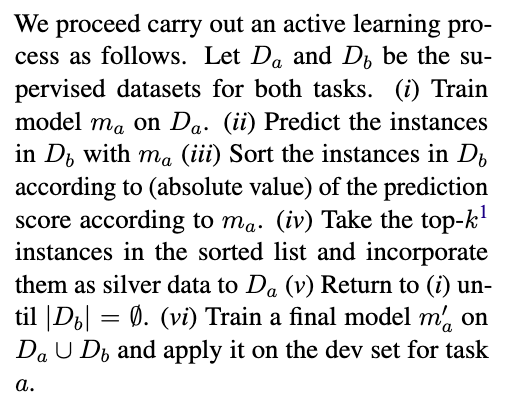

SAMPLING

This approach is used when we have a large dataset.
In this approach, we split our dataset into three parts: Training Set; Test Set; Unlabeled Pool(ironical) [5%; 25%, 70%].
This training dataset is our initial dataset and is used to initially train our model.
This approach selects valuable/uncertain points from this unlabeled pool, this ensures that all the query can be recognized by human oracle

1. train classifier with the initial training dataset
2. calculate the accuracy
3. while(accuracy < desired accuracy):

*   select the most valuable data points (in general points close to decision boundary)
*   query that data point/s (ask for a label) from human oracle
*   add that data point/s to our initial training dataset
*   re-train the model
*   re-calculate the accuracy



```
# Dividere Homo per 1 e 0 
# 0 viene tenuto tutto 
# 1 viene filtrato: primi 200 in ordine crescente di proba per 1 
# Concat 
# L'ultima fase di training prevede un nuovo modello allenato su hope train hope dev e homo filtrato 
# Test_2022 
```

## Prep. Data from * 'Hope'

In [30]:
dataTrain = pd.read_csv("Hope_ENG_train.csv", header=None)
dataDev = pd.read_csv("Hope_ENG_dev.csv", header=None)
dataTest = pd.read_csv("english_hope_test.csv", header=0, sep=';')
dataTest = dataTest.rename(columns={'label': 1})
dataTest = dataTest.rename(columns={'text': 0})
dataTest = dataTest[[0,1]]
dataTest = dataTest[dataTest[1] != 'not-English']
data_test = pd.concat([dataTrain,dataDev,dataTest])
data_test = data_test.dropna()
data_test = data_test.rename(columns={1: "labels"})
data_test = data_test.rename(columns={0: 'text'})
data_test

In [33]:
dataTrain = pd.read_csv("Hope_ENG_train.csv")
dataDev = pd.read_csv("Hope_ENG_dev.csv")
dataTest = pd.read_csv("english_hope_test.csv", header=0, sep=';')
data_test = pd.concat([dataTrain,dataDev])

In [34]:
data_test = data_test.rename(columns={'label;;': 'labels'})

In [35]:
data_test.labels.value_counts()

Non_hope_speech;;    23258
Hope_speech;;         2217
Non_hope_speech;        77
Hope_speech;            16
Non_hope_speech         12
Hope_speech              1
Name: labels, dtype: int64

In [36]:
data_test['labels'] = data_test.apply(lambda row: label_col_Hope(row), axis=1)
data_test

,text,labels
0,these tiktoks radiate gay chaotic energy and i...,1
1,@Champions Again He got killed for using false...,1
2,It's not that all lives don't matter,1
3,Is it really that difficult to understand? Bla...,1
4,Whenever we say black isn't that racists? Why...,1
...,...,...
2836,Such fake sentiment. .,1
2837,@A G black lives arent undervalued compared to...,1
2838,People who pulled it down can and will be arre...,1
2839,@Aaron Castellanos It will be a two hour movie...,1


In [37]:
data_test.labels.value_counts()

1    23347
0     2234
Name: labels, dtype: int64

## Active Learning Calls 

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

drive.mount('/content/gdrive') 

model_save_name = 'homo_active_learning_it0_lt.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [41]:
poolData = data_test 
# We take the best F1 score so far, i.e. from the training of the original model on train + dev Hope 2022
best_score = current_score
print("Orig. Train "+str(len(data)))
print(best_score)
print()
print("Starting Pool Data size "+str(len(poolData)))
# We select all the instances beloging to 0, i.e. hope, i.e., non offensive content 
temp = poolData[poolData['labels'] == 0]
print("Added to Train "+str(len(temp)))
# Remove non_hope (trans and homophobic) from poolData
poolData = poolData[poolData['labels'] != 0] 
print("Remaining Pool Data size "+str(len(poolData)))
# Concat non_hope (trans and homophobic) to the training + dev Hope 2022 
data = pd.concat([data,temp])   
data

Orig. Train 4088
0.9617832676731457

Starting Pool Data size 25581
Added to Train 2234
Remaining Pool Data size 23347


,labels,text
0,0,"I support her, very smart ponnu"
1,1,priyadharshini kannan same gender attraction ...
2,0,Bro u name and phone number (or)mobile number ...
3,0,experience Thaks bro I love you so much bro ...
4,0,world is becoming bad day by day....
...,...,...
2792,0,i’m actually about to start my college on civi...
2801,0,@Sasha Dumse that is true. But we should ALL l...
2808,0,Women need to keep fighting
2833,0,“God gave me a choice and my choice is love” t...


In [47]:
print("--- Iteration 0")
print("Orig. Train + HomoTransphobic instances "+str(len(data)))
# Train new model with this "step 0" of Active Learning 
model,current_score = trainBERT(data)
print(current_score)
print()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


--- Iteration 0
Orig. Train + HomoTransphobic instances 6322
[print in trainBERT] -- Data Composition 
                  text
labels data_type      
0      train      5267
       val         699
1      train       189
       val          26
2      train       126
       val          15
[print in trainBERT] -- Len Train 6322
[print in trainBERT] -- Len Train after dropping NaN 6322


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1396 [00:00<?, ?it/s]


Epoch 1/4
Training loss: 0.2918372134685404
Validation loss: 0.2398182437556947
F1 Score(weighted) : 0.9287740445378442
Prec Score(weighted) : 0.9173784518213867
Recall Score(weighted) : 0.95
Acc Score : 0.95


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2:   0%|          | 0/1396 [00:00<?, ?it/s]


Epoch 2/4
Training loss: 0.15229869441886135
Validation loss: 0.23373009699083727
F1 Score(weighted) : 0.9430654625569881
Prec Score(weighted) : 0.9444096218154796
Recall Score(weighted) : 0.9567567567567568
Acc Score : 0.9567567567567568


Epoch 3:   0%|          | 0/1396 [00:00<?, ?it/s]


Epoch 3/4
Training loss: 0.061057194555086555
Validation loss: 0.2644435711782756
F1 Score(weighted) : 0.9500294728993767
Prec Score(weighted) : 0.9456512855571434
Recall Score(weighted) : 0.9581081081081081
Acc Score : 0.9581081081081081


Epoch 4:   0%|          | 0/1396 [00:00<?, ?it/s]


Epoch 4/4
Training loss: 0.025140386653803793
Validation loss: 0.2679101108230424
F1 Score(weighted) : 0.9510454989794164
Prec Score(weighted) : 0.9479288111641052
Recall Score(weighted) : 0.9594594594594594
Acc Score : 0.9594594594594594
0.9510454989794164



In [48]:
# If the new score is better than the last, update  
if current_score > best_score:
  temp = best_score
  best_score = current_score
  current_score = temp 
print("Best score so far "+str(best_score)) 

Best score so far 0.9617832676731457


In [50]:
best_score = 0.9617832676731457

In [51]:
path = "/content/gdrive/My Drive/homo_active_learning_it0_lt.pt" 
model = torch.load(path)
model.to(device)  
model 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [52]:
poolData

,text,labels
0,these tiktoks radiate gay chaotic energy and i...,1
1,@Champions Again He got killed for using false...,1
2,It's not that all lives don't matter,1
3,Is it really that difficult to understand? Bla...,1
4,Whenever we say black isn't that racists? Why...,1
...,...,...
2835,TheLegend27 Is Alive she is literally a boy lol,1
2836,Such fake sentiment. .,1
2837,@A G black lives arent undervalued compared to...,1
2838,People who pulled it down can and will be arre...,1


In [53]:
model_save_name = 'homo_active_learning_lt.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 

In [54]:
k = 200  
i = 0 
print("Best score so far "+str(best_score)) 
print()
print("Starting Pool Data size "+str(len(poolData)))
print()
# While there is poolData to draw from
while len(poolData) > 0: 
  # Gathering predictions on poolData
  poolDataWithP = predOnTestData(poolData)
  # Keeping only the instances that the model classified as 1, i.e., hope_speech   
  poolDataWithP = poolDataWithP[poolDataWithP["pred"] == 1] 
  if not poolDataWithP.empty:
    # Keeping only the topK, remove from poolData the topK 
    topK,poolData = findTopK(poolDataWithP, k)     
    print("Added to Train "+str(len(topK))) # Should be 200!
    # Concat topK to train data so far  
    data = pd.concat([data,topK])  
    i = i + 1 
    print("--- Iteration "+str(i))
    print("Active Learning Dataset size "+str(len(data)))
    print("Remaining Pool Data size "+str(len(poolData)))
    print()
    # Train a new model on the "augmented training data" 
    model,current_score = trainBERT(data)
    print(current_score)
    print()
    # Check if there is an improvement 
    if current_score > best_score:
      temp = best_score
      best_score = current_score
      current_score = temp 
    else: 
      break
  else: 
    print("No 1s predicted, Active Learning stops")
    break
    
print("Final best score "+str(best_score)) 

Best score so far 0.9617832676731457

Starting Pool Data size 23347



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on

[print in findTopK] -- Len poolData after removing topK for both classes37
[print in findTopK] -- Print topK
                                                  text  labels
0    Know ye not that the unrighteous shall not inh...       1
1            That change is going against God Almighty       1
2    Good will be bad and bad will be goodnCalling ...       1
3                         throws bible into headnnYeah       1
4    Just like ISIS and Taliban....destroying histo...       1
..                                                 ...     ...
189  I vote on deporting all windrush descendants. ...       1
190                   Go to Juan for stupid every time       1
191        That guy did a wrong thing and was murdered       1
192  obviously the mosques will now be burnt to the...       1
193        you fucking comunist comevsay it in my face       1

[194 rows x 2 columns]
[print in findTopK] -- Print remaining poolData
                                                 text  labels
0

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1431 [00:00<?, ?it/s]


Epoch 1/4
Training loss: 0.33046761429440724
Validation loss: 0.2557975473634974
F1 Score(weighted) : 0.9305939170702221
Prec Score(weighted) : 0.920947570947571
Recall Score(weighted) : 0.9406565656565656
Acc Score : 0.9406565656565656


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2:   0%|          | 0/1431 [00:00<?, ?it/s]


Epoch 2/4
Training loss: 0.17741692391368444
Validation loss: 0.27975571023691576
F1 Score(weighted) : 0.9529975217275254
Prec Score(weighted) : 0.9548826730829436
Recall Score(weighted) : 0.9570707070707071
Acc Score : 0.9570707070707071


Epoch 3:   0%|          | 0/1431 [00:00<?, ?it/s]


Epoch 3/4
Training loss: 0.0727974788758063
Validation loss: 0.27905034604029627
F1 Score(weighted) : 0.9543234543234542
Prec Score(weighted) : 0.9559545274661554
Recall Score(weighted) : 0.9583333333333334
Acc Score : 0.9583333333333334


Epoch 4:   0%|          | 0/1431 [00:00<?, ?it/s]


Epoch 4/4
Training loss: 0.031019783763839
Validation loss: 0.27539019065939513
F1 Score(weighted) : 0.9570723436831444
Prec Score(weighted) : 0.9570504796805582
Recall Score(weighted) : 0.9595959595959596
Acc Score : 0.9595959595959596
0.9570723436831444

Final best score 0.9617832676731457


## Pred on Test 'Homo' 2022 (UNlabeled!) 

In [55]:
path = "/content/gdrive/My Drive/homo_active_learning_lt.pt" 
model = torch.load(path)
model.to(device)  
model 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [71]:
data_test = pd.read_excel('homo_test.xlsx')
data_test.to_csv('data.csv')
data_test = pd.read_csv('data.csv')
data_test = data_test.drop(['Unnamed: 0'], axis = 1)
data_test = data_test.rename(columns={'text                    ': 'text'})
data_test = data_test.dropna()
data_test

,text
0,Spr....2016 poitan feel happy with my partner ...
1,R u still with ur partner
2,excellent movie..no unnecessary drama or scene...
3,"For those who speak about culture., pre marita..."
4,Best movie and people not understand relations...
...,...
985,Looks like Karthik took advantage on Varun whe...
986,i am really crying pro😢😢😢😭😭😭😭😭😭 ...
987,They may be transgender but don't ever forgot ...
988,It is their own choice. I support them No doub...


In [72]:
data_test = predOnTestData(data_test)
data_test

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


,text,pred,probs_0,probs_1,probs_2
0,Spr....2016 poitan feel happy with my partner ...,0,0.999894,0.000068,0.000039
1,R u still with ur partner,0,0.999795,0.000121,0.000084
2,excellent movie..no unnecessary drama or scene...,0,0.999865,0.000098,0.000037
3,"For those who speak about culture., pre marita...",0,0.999744,0.000171,0.000084
4,Best movie and people not understand relations...,0,0.999914,0.000053,0.000033
...,...,...,...,...,...
985,Looks like Karthik took advantage on Varun whe...,0,0.999726,0.000216,0.000058
986,i am really crying pro😢😢😢😭😭😭😭😭😭 ...,0,0.999810,0.000082,0.000108
987,They may be transgender but don't ever forgot ...,0,0.999870,0.000069,0.000061
988,It is their own choice. I support them No doub...,0,0.999850,0.000077,0.000073


In [76]:
data_test.pred.value_counts()

0    956
1     30
2      4
Name: pred, dtype: int64

In [77]:
preds = data_test['pred']

In [60]:
#data_test.to_excel('preds_homo_AL_numbers.xlsx', index=False)

In [78]:
def label_col(row):
  if row['pred'] == 0:#'Non-anti-LGBT+ content':
    return 'Non-anti-LGBT+ content'
  if row['pred'] == 1: #'Homophobic':
    return 'Homophobic'
  if row['pred'] == 2:#'Transphobic':
    return 'Transphobic'

In [79]:
data_test['pred'] = data_test.apply(lambda row: label_col(row), axis=1)
data_test

,text,pred,probs_0,probs_1,probs_2
0,Spr....2016 poitan feel happy with my partner ...,Non-anti-LGBT+ content,0.999894,0.000068,0.000039
1,R u still with ur partner,Non-anti-LGBT+ content,0.999795,0.000121,0.000084
2,excellent movie..no unnecessary drama or scene...,Non-anti-LGBT+ content,0.999865,0.000098,0.000037
3,"For those who speak about culture., pre marita...",Non-anti-LGBT+ content,0.999744,0.000171,0.000084
4,Best movie and people not understand relations...,Non-anti-LGBT+ content,0.999914,0.000053,0.000033
...,...,...,...,...,...
985,Looks like Karthik took advantage on Varun whe...,Non-anti-LGBT+ content,0.999726,0.000216,0.000058
986,i am really crying pro😢😢😢😭😭😭😭😭😭 ...,Non-anti-LGBT+ content,0.999810,0.000082,0.000108
987,They may be transgender but don't ever forgot ...,Non-anti-LGBT+ content,0.999870,0.000069,0.000061
988,It is their own choice. I support them No doub...,Non-anti-LGBT+ content,0.999850,0.000077,0.000073


In [80]:
data_test.to_excel('preds_homo_AL.xlsx', index=False)
from google.colab import files
files.download('preds_homo_AL.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>